# Install extra packages

In [23]:
!pip install -q -U tensorflow_addons
!pip install -q keras-nlp
!pip install -q tqdm
!pip install -q scikit-learn 
!pip install -q pandas
!pip install -q matplotlib


[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python -m pip install --upgrade pip


# Hyperparameters

In [45]:
file_id = '1w3IQMK3PmXH-Bq6Lt_P8wxGPvr5olrZT'
destination = 'pfam.zip'
n_families_of_interest = 3000
data_dirpath = "pfam"
os.makedirs("models", exist_ok=True)

# Import Data

In [25]:
import os
import requests
import tqdm
import json
import pandas as pd
import numpy as np
from collections import Counter
import zipfile
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, Dense, GlobalAveragePooling1D, LayerNormalization, Dropout
from tensorflow.keras.models import Model

import tensorflow.keras as keras
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras import layers
from functools import partial 

import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np
import os
import gc

In [12]:
def format_size(value):
  if value >= 1024**3:
    return f"{round(value / 1024**3 , 3)} GB"
  elif value >= 1024**2:
    return f"{round(value / 1024**2 , 3)} MB"
  elif value >= 1024:
    return f"{round(value / 1024 , 3)} KB"
  return f"{value} B"

# Code taken from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    params = { 'id' : id, 'confirm' : 1 }
    response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    
    pb = tqdm.tqdm(response.iter_content(CHUNK_SIZE))
    b_total = 0
    with open(destination, "wb") as f:
        for i,chunk in enumerate(pb):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                b_total += len(chunk)

                if i % 1000 == 0:
                  pb.set_description(f"written : {format_size(b_total)}")
                i += 1
    print("\n")
    print(f"saved all the data to {destination}. total size : {format_size(os.stat(destination).st_size)}")

In [19]:
download_file_from_google_drive(file_id, destination)
with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall(".")
!mv random_split pfam

written : 468.781 MB: : 15780it [00:10, 1502.62it/s]




saved all the data to pfam.zip. total size : 493.095 MB


In [26]:
data_dirpath = "pfam"
print('Available dataset partitions: ', os.listdir(data_dirpath))

Available dataset partitions:  ['train', 'test', 'random_split', 'dev']


In [27]:
def read_all_shards(partition='dev', data_dir = data_dirpath):
    shards = []
    for fn in os.listdir(os.path.join(data_dir, partition)):
        with open(os.path.join(data_dir, partition, fn)) as f:
            shards.append(pd.read_csv(f, index_col=None))
    
    return pd.concat(shards)

def read_all_data_initial():
  global train, test, dev, all_train_ds_size, all_test_ds_size, all_dev_ds_size

  test = read_all_shards('test')
  dev = read_all_shards('dev')
  train = read_all_shards('train')

  partitions = {'test': test, 'dev': dev, 'train': train}
  for name, df in partitions.items():
      print('Dataset partition "%s" has %d sequences' % (name, len(df)))

  all_train_ds_size = len(train)
  all_test_ds_size = len(test)
  all_dev_ds_size = len(dev)

  train.reset_index(inplace=True, drop=True)
  dev.reset_index(inplace=True, drop=True)
  test.reset_index(inplace=True, drop=True)

read_all_data_initial()

Dataset partition "test" has 126171 sequences
Dataset partition "dev" has 126171 sequences
Dataset partition "train" has 1086741 sequences


In [28]:
def plot_counts(data):

    counter = Counter(data['family_accession'])
    print(f"how many labels : {len(counter)}")
    
    datasetSize = len(data)
    xs = []
    x_labels = []
    ys = []

    t = 0
    cumulative = []

    for i,(x, y) in  enumerate(counter.most_common()):
        xs.append(i)
        x_labels.append(x)
        ys.append(y)
        t += y / datasetSize
        cumulative.append(t)

    plt.figure(figsize=(16 ,6))
    plt.subplot(1, 2, 1)
    plt.plot(xs, ys)
    plt.yscale("log")

    plt.subplot(1, 2, 2)
    plt.plot(xs, cumulative)
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
    plt.show()
    return cumulative


how many labels : 17929


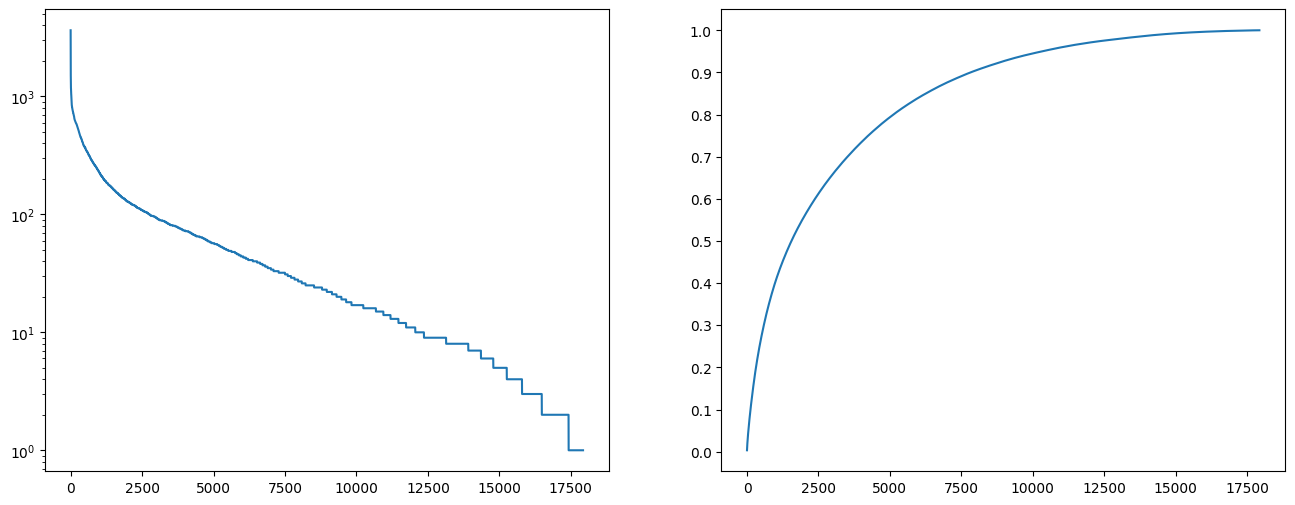

In [29]:
cumulative = plot_counts(train)

In [31]:
print(f"{n_families_of_interest} classes is {100 * round( cumulative[n_families_of_interest-1],3)} portion of training data")

3000 classes is 65.9 portion of training data


# Create keras dataset

how many labels : 3000


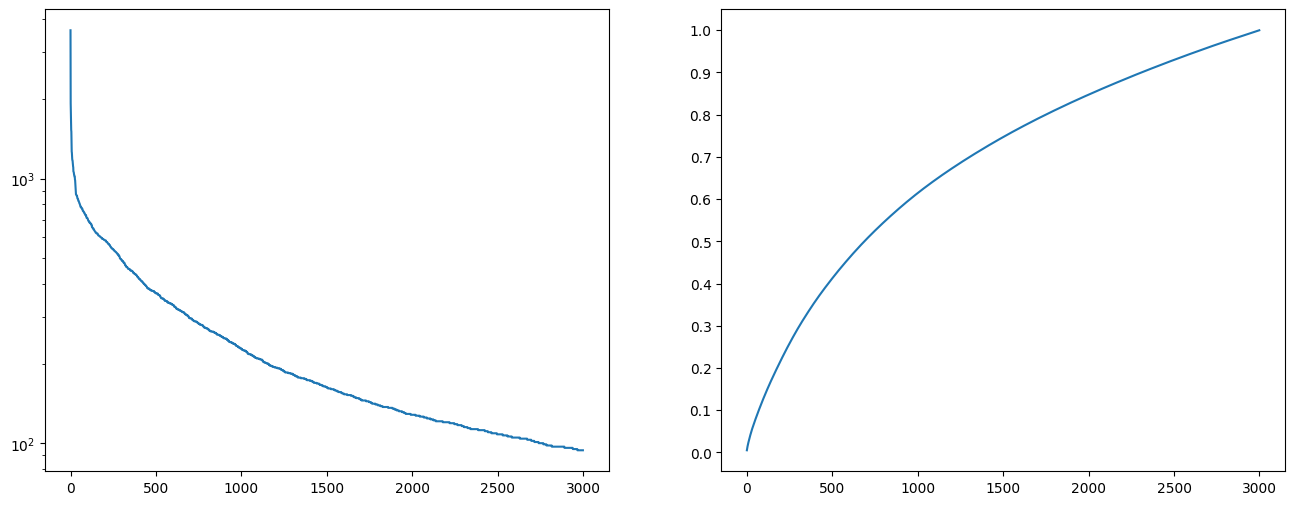

In [33]:
familiesOfInterest = train.family_accession.value_counts()[:n_families_of_interest]

mask = train.family_accession.isin(familiesOfInterest.index.values)
train = train.loc[mask,:]

mask = dev.family_accession.isin(familiesOfInterest.index.values)
dev = dev.loc[mask,:]

mask = test.family_accession.isin(familiesOfInterest.index.values)
test = test.loc[mask,:]

cumulative_split = plot_counts(train)

In [34]:
train_seq = train['sequence']
dev_seq = dev['sequence']
test_seq = test['sequence']

In [35]:
train_sentences = train_seq.apply(lambda seq: [aa for aa in seq])
validation_sentences = dev_seq.apply(lambda seq: [aa for aa in seq])
test_sentences = test_seq.apply(lambda seq: [aa for aa in seq])

In [36]:
train_labels = train['family_accession'].apply(lambda x: x.split('.')[0])
validation_labels = dev['family_accession'].apply(lambda x: x.split('.')[0])
test_labels = test['family_accession'].apply(lambda x: x.split('.')[0])

label_tokenizer = Tokenizer(oov_token = -1)
label_tokenizer.fit_on_texts(train_labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))
test_label_seq = np.array(label_tokenizer.texts_to_sequences(test_labels))

training_label_seq = training_label_seq-1
validation_label_seq = validation_label_seq-1
test_label_seq = test_label_seq-1

In [37]:
vocab_size = 25
embedding_dim = vocab_size
max_length = 512
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"
training_portion = .8

tokenizer = Tokenizer(oov_token=oov_tok, num_words = vocab_size)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
print(word_index)

{'<OOV>': 1, 'l': 2, 'a': 3, 'g': 4, 'v': 5, 'e': 6, 'i': 7, 's': 8, 'r': 9, 'd': 10, 't': 11, 'k': 12, 'p': 13, 'f': 14, 'n': 15, 'q': 16, 'y': 17, 'm': 18, 'h': 19, 'c': 20, 'w': 21, 'x': 22, 'u': 23, 'b': 24, 'o': 25}


In [38]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
print(train_sequences[0])
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type)
print(train_padded[0])

[9, 7, 4, 7, 18, 11, 8, 4, 4, 10, 3, 13, 4, 18, 15, 2, 3, 7, 9, 3, 5, 3, 9, 12, 3, 2, 8, 8, 4, 2, 6, 3, 17, 4, 7, 15, 17, 4, 14, 3, 4, 2, 5, 3, 4, 10, 7, 19, 6, 14, 12, 3, 3, 10, 2, 10, 10, 18, 5, 8, 16, 4, 4, 11, 18, 2, 17, 8, 3, 9, 17, 13, 6, 14, 3, 16, 6, 6, 8, 16, 2, 12, 4, 7, 6, 16, 2, 12, 12, 14, 4, 7, 10, 3, 2, 5, 5, 7, 4, 4, 10, 4, 8, 17, 19, 4, 3, 2, 9, 2, 11, 6, 19, 4, 17, 15, 11, 7, 4, 2, 13, 4, 11, 7, 10, 15, 10, 7, 13, 14, 11, 10, 14, 11, 7, 4, 14, 10, 11, 3, 2, 15, 11, 3, 5, 10, 3, 7, 10, 12, 7, 9, 10, 11, 3, 12, 8, 19, 16, 9, 5, 14, 3, 5, 16, 5, 18, 4, 9, 15, 3, 3, 10, 7, 3, 2, 21, 3, 4, 5, 3, 8, 4, 3, 10, 3, 5, 7, 3, 13, 4, 14, 10, 17, 10, 5, 6, 3, 7, 3, 15, 12, 2, 12, 12, 15, 9, 3, 15, 4, 12, 10, 17, 4, 7, 7, 5, 7, 3, 6, 4, 10, 3, 15, 8, 10, 3, 3, 13, 6, 14, 7, 10, 16, 2, 12, 16, 17, 4, 10, 14, 10, 3, 9, 3, 11, 5, 7, 4, 19, 5, 16, 9, 4, 4, 5, 13, 8, 3, 12, 10, 9, 5, 2, 3, 8, 12, 18, 4, 3, 17, 3, 5, 6, 2, 2]
[ 9  7  4  7 18 11  8  4  4 10  3 13  4 18 15  2  3  7  9  3  

In [39]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type)

In [40]:
print(train_padded.shape)
print(validation_padded.shape)
print(test_padded.shape)
print(train_padded[0])

(715645, 512)
(87755, 512)
(87755, 512)
[ 9  7  4  7 18 11  8  4  4 10  3 13  4 18 15  2  3  7  9  3  5  3  9 12
  3  2  8  8  4  2  6  3 17  4  7 15 17  4 14  3  4  2  5  3  4 10  7 19
  6 14 12  3  3 10  2 10 10 18  5  8 16  4  4 11 18  2 17  8  3  9 17 13
  6 14  3 16  6  6  8 16  2 12  4  7  6 16  2 12 12 14  4  7 10  3  2  5
  5  7  4  4 10  4  8 17 19  4  3  2  9  2 11  6 19  4 17 15 11  7  4  2
 13  4 11  7 10 15 10  7 13 14 11 10 14 11  7  4 14 10 11  3  2 15 11  3
  5 10  3  7 10 12  7  9 10 11  3 12  8 19 16  9  5 14  3  5 16  5 18  4
  9 15  3  3 10  7  3  2 21  3  4  5  3  8  4  3 10  3  5  7  3 13  4 14
 10 17 10  5  6  3  7  3 15 12  2 12 12 15  9  3 15  4 12 10 17  4  7  7
  5  7  3  6  4 10  3 15  8 10  3  3 13  6 14  7 10 16  2 12 16 17  4 10
 14 10  3  9  3 11  5  7  4 19  5 16  9  4  4  5 13  8  3 12 10  9  5  2
  3  8 12 18  4  3 17  3  5  6  2  2  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  

In [41]:
print(train_padded.shape)
print(validation_padded.shape)
print(test_padded.shape)
print(train_padded[0])

(715645, 512)
(87755, 512)
(87755, 512)
[ 9  7  4  7 18 11  8  4  4 10  3 13  4 18 15  2  3  7  9  3  5  3  9 12
  3  2  8  8  4  2  6  3 17  4  7 15 17  4 14  3  4  2  5  3  4 10  7 19
  6 14 12  3  3 10  2 10 10 18  5  8 16  4  4 11 18  2 17  8  3  9 17 13
  6 14  3 16  6  6  8 16  2 12  4  7  6 16  2 12 12 14  4  7 10  3  2  5
  5  7  4  4 10  4  8 17 19  4  3  2  9  2 11  6 19  4 17 15 11  7  4  2
 13  4 11  7 10 15 10  7 13 14 11 10 14 11  7  4 14 10 11  3  2 15 11  3
  5 10  3  7 10 12  7  9 10 11  3 12  8 19 16  9  5 14  3  5 16  5 18  4
  9 15  3  3 10  7  3  2 21  3  4  5  3  8  4  3 10  3  5  7  3 13  4 14
 10 17 10  5  6  3  7  3 15 12  2 12 12 15  9  3 15  4 12 10 17  4  7  7
  5  7  3  6  4 10  3 15  8 10  3  3 13  6 14  7 10 16  2 12 16 17  4 10
 14 10  3  9  3 11  5  7  4 19  5 16  9  4  4  5 13  8  3 12 10  9  5  2
  3  8 12 18  4  3 17  3  5  6  2  2  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  

In [ ]:
def plot_history(data):
  plt.plot(data['loss'], label="loss")
  plt.plot(data['val_loss'], label="val_loss")
  plt.legend()
  plt.show()

  plt.plot(data['accuracy'], label="accuracy")
  plt.plot(data['val_accuracy'], label="val_accuracy")
  plt.legend()
  plt.show()

def train_network(get_model, save_path, epochs=25, INIT_LR=1e-4, MAX_LR=1e-3, BATCH_SIZE=32):
  steps_per_epoch = len(train_sequences) // BATCH_SIZE
  clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
      maximal_learning_rate=MAX_LR,
      scale_fn=lambda x: 1/(2.**(x-1)),
      step_size=2 * steps_per_epoch
  )

  es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', min_delta=0.01, patience=5)
  save_model_cb = tf.keras.callbacks.ModelCheckpoint(save_path, monitor = "accuracy", verbose= 1, save_best_only = True) 

  model = get_model()
  optimizer = tf.keras.optimizers.Adam(clr)
  model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
  model.summary()

  history = model.fit(train_padded, training_label_seq, epochs=epochs, validation_data=(validation_padded, validation_label_seq), 
                      callbacks = [es_cb , save_model_cb])
  
  data = history.history
  plot_history(data)
  return history

# ProtCNN

## Architecture

In [43]:
def residual_block(x, dil, filters, ks=3):
    shortcut = x
    bn1 = tf.keras.layers.BatchNormalization()(x)
    a1 = tf.keras.layers.Activation("relu")(x)
    conv1 = tf.keras.layers.Conv1D(filters, ks, dilation_rate=dil, padding="same")(x)
    
    bn2 = tf.keras.layers.BatchNormalization()(conv1)
    a2 = tf.keras.layers.Activation("relu")(bn2)
    conv2 = tf.keras.layers.Conv1D(filters, ks, padding="same")(a2)
    
    x = tf.keras.layers.Add()([conv2, shortcut])
    return x


def getProtCNN(numclass, residuals_ks=3, residuals_filters=64):
    input_x = tf.keras.layers.Input(shape=(512, ))
    x = tf.keras.layers.Embedding(vocab_size, vocab_size, embeddings_initializer=tf.keras.initializers.Identity(gain=1.0), trainable=False)(input_x)
    x = tf.keras.layers.Permute(dims=[2, 1])(x)
    x = tf.keras.layers.Conv1D(64, 8, padding="same")(x)
    x = residual_block(x, 1, residuals_filters, ks=residuals_ks)
    x = residual_block(x, 2, residuals_filters, ks=residuals_ks)
    x = tf.keras.layers.Permute(dims=[2, 1])(x)
    x = tf.keras.layers.Conv1D(64, 3, padding="same")(x)
    x = residual_block(x, 1, residuals_filters, ks=residuals_ks)
    x = residual_block(x, 2, residuals_filters, ks=residuals_ks)
    x = tf.keras.layers.Lambda(lambda x: K.expand_dims(x, -1))(x) #will not compile if not defined as lambda
    x = tf.keras.layers.Conv2D(32, (4,4), padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Conv2D(8, (8,8), padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.MaxPooling2D((64,64))(x)
    #x = tf.keras.layers.Conv1D(8, 8, padding="same")(x)
    #x = tf.keras.layers.MaxPooling1D(64)(x)
    x = tf.keras.layers.Flatten()(x)
    out = tf.keras.layers.Dense(numclass+1, activation="softmax")(x)

    model = tf.keras.Model(inputs=input_x, outputs=out)
    return model

## Experiment 1

In [46]:
model = partial(partial(getProtCNN, n_families_of_interest))
train_network(model, os.path.join("models", "protCNN_exp1.h5"), epochs=1)

2023-04-22 22:15:15.894245: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22077 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c1:00.0, compute capability: 8.9


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 512, 25)      625         ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 25, 512)      0           ['embedding[0][0]']              
                                                                                                  
 conv1d (Conv1D)                (None, 25, 64)       262208      ['permute[0][0]']                
                                                                                              

2023-04-22 22:15:21.049222: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:417] Loaded runtime CuDNN library: 8.4.0 but source was compiled with: 8.6.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2023-04-22 22:15:21.050081: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at conv_ops.cc:1068 : UNIMPLEMENTED: DNN library is not found.
2023-04-22 22:15:21.050125: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:GPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): UNIMPLEMENTED: DNN library is not found.
	 [[{{node model/conv1d/Conv1D}}]]


UnimplementedError: Graph execution error:

Detected at node 'model/conv1d/Conv1D' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.10/dist-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_364/3158395036.py", line 2, in <module>
      train_network(model, os.path.join("models", "protCNN_exp1.h5"), epochs=1)
    File "/tmp/ipykernel_364/193760011.py", line 28, in train_network
      history = model.fit(train_padded, training_label_seq, epochs=epochs, validation_data=(validation_padded, validation_label_seq),
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/usr/local/lib/python3.10/dist-packages/keras/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'model/conv1d/Conv1D'
DNN library is not found.
	 [[{{node model/conv1d/Conv1D}}]] [Op:__inference_train_function_5119]